## INFO

<b>STEPS</b>

1. Hope to get excel with tab per question

2. Break each tab into .csv file (should be 5 files)

3. Generate topics for each file, sentiment analysis

4. For each topic, generate phrase frequency chart (1,3)


<b>INFO</b>
- Should result in excel with 5 tabs (original plus topic and sentiment)
- 5 summary tables to show roll up of topics (one per question)
- 10 phrase frequency charts per file (chart for each topic under each question)



<b>CALLOUT</b>
- if -1 topic is large
- all observations fall in less than 10 topics
- there seems to be a need for more than 10 topics

In [1]:
# Import packages
import os
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt

# Analytics/Metrics
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

In [2]:
dirname = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Chevron Survey\\Input_Data\\"

filename = ['Question1.csv', 'Question2.csv', "Question3.csv", "Question4.csv", "Question5.csv"]

df = pd.read_csv(str(dirname)+str(filename))

In [4]:
df.tail()

,Text,Category,Page,File
2027,Reuters (10/3) reports the US Department of En...,Text,4,[__EXTERNAL__] Chevron New Energies Daily News...
2028,Clean Air Task Force Says World’s Biofuel Supp...,Title,4,[__EXTERNAL__] Chevron New Energies Daily News...
2029,"Bloomberg Law (10/3, Ryan) reports the climate...",Text,4,[__EXTERNAL__] Chevron New Energies Daily News...
2030,Back to top ▲,Text,4,[__EXTERNAL__] Chevron New Energies Daily News...
2031,"© 2022 Cision. All rights reserved, excluding ...",Text,4,[__EXTERNAL__] Chevron New Energies Daily News...


## Variables

In [10]:
# ========================= #
# Stuff for BERTopic & Sentiment
# ========================= #

TEXT_FIELD = "Text"
NUM_TOPICS = 10


# ========================= #
# Stuff for outputting data
# ========================= #
Improved_Data_Dirname = "C:\\Users\\hlmq\\OneDrive - Chevron\\Desktop\\Projects\\Chevron Survey\\Improved_Data\\"

SUBJECT = 'Question1'


## NLP and Metrics

Steps:

- Topic Modeling (BERTopic)

- Analyze Sentiment for each tweet
- Count # of tweets in subject [GLOBAL]
- Count # of tweets in topic [Local]
- CountWordFrequency across subject
- Log accounts (most frequent mentions or other?)


In [11]:
# Prepare embeddings
docs = df[TEXT_FIELD].tolist()
sentence_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = sentence_model.encode(docs, show_progress_bar=True)

vectorizer_model = CountVectorizer(ngram_range=(1, 3), stop_words="english", min_df=2)

topic_model = BERTopic(nr_topics = NUM_TOPICS, #max number of topics
                       language = 'english',
                       vectorizer_model = vectorizer_model,
                       calculate_probabilities = True,
                       verbose=True)

topics, probabilities = topic_model.fit_transform(docs, embeddings)

Batches:   0%|          | 0/64 [00:00<?, ?it/s]

2023-06-08 16:24:27,095 - BERTopic - Reduced dimensionality
2023-06-08 16:24:27,975 - BERTopic - Clustered reduced embeddings
2023-06-08 16:24:30,574 - BERTopic - Reduced number of topics from 46 to 11


In [13]:
# Topic -1 is the catch-all bin for outliers.
# Need to modify min_df.  Believe this is the minimum number of obs to create a topic.
# From word frequency, believe ngram = 2 is good.
# ACTION: Generate more tweets and test with different min_df value.

topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1024,-1_energy_hydrogen_reports_said
1,0,141,0_news_chevron new energies_new energies_chevr...
2,1,137,1_hydrogen_green hydrogen_green_plug
3,2,111,2_climate_executive_republicans_house
4,3,110,3____
5,4,105,4_climate_cop27_countries_nations
6,5,99,5_ammonia_hydrogen_green_indonesia
7,6,86,6_data_content_platforms_including
8,7,84,7_aviation_saf_sustainable_sustainable aviation
9,8,69,8_ccus_ccs_projects_capture


In [19]:
df_with_topics = pd.DataFrame(topic_model.get_document_info(docs))

In [20]:
df_with_topics.head()

,Document,Topic,Name,Top_n_words,Probability,Representative_document
0,Be aware this external email contains an attac...,-1,-1_energy_hydrogen_reports_said,energy - hydrogen - reports - said - carbon - ...,0.986912,False
1,Click to access mobile-optimized online versio...,6,6_data_content_platforms_including,data - content - platforms - including - third...,0.409549,True
2,executive summary,2,2_climate_executive_republicans_house,climate - executive - republicans - house - en...,0.233453,True
3,Key Insights.,-1,-1_energy_hydrogen_reports_said,energy - hydrogen - reports - said - carbon - ...,0.984452,False
4,"BizCrast (11/12, Johnson) reported that Chevro...",-1,-1_energy_hydrogen_reports_said,energy - hydrogen - reports - said - carbon - ...,0.857765,False


In [21]:
topic_model.visualize_hierarchy()

## Add Sentiment

In [34]:
import spacy

nlp = spacy.load("en_core_web_lg")

sentiment_analyzer = nlp.pipeline("sentiment-analysis")

df_with_topics['Sentiment'] = sentiment_analyzer(docs)

TypeError: 'SimpleFrozenList' object is not callable

## Output to DF

In [ ]:
# Create name of file

# Just creates the string with {path} and {filename} ready to go
OUT_FILE = os.path.join(Improved_Data_Dirname, "{timestamp}_{subject}.csv".format(timestamp=date.today(), subject=SUBJECT))
print(OUT_FILE)

In [ ]:
df.to_csv(OUT_FILE, index=False)

## Slice for Phrase Counter

In [22]:
# Count total len of df

list_of_topics = df_with_topics['Name'].nunique()

for i in topic_model.topics_:
    sliced_df = df[df["Topic"]==i]
    print(len(sliced_df))

TypeError: 'int' object is not iterable

Text(0.5, 1.0, 'Most Common Words from this Subject')

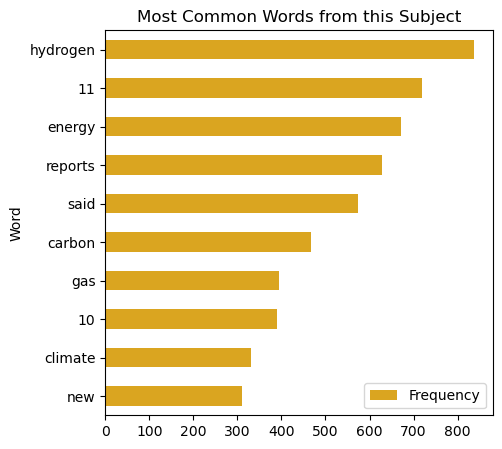

In [15]:
# CountWordFrequency

#Create DTM
cv = CountVectorizer(ngram_range = (1,3), stop_words='english')
dtm = cv.fit_transform(df[TEXT_FIELD])
words = np.array(cv.get_feature_names_out())

#Look at top 15 most frequent words
freqs=dtm.sum(axis=0).A.flatten()
index=np.argsort(freqs)[-10:]

# Construct dataframe
WordFreq = pd.DataFrame.from_records(list(zip(words[index], freqs[index])))
WordFreq.columns = ['Word', 'Frequency']

# Plot horizontal bar graph
fig, ax = plt.subplots(figsize=(5, 5))
WordFreq.sort_values(by='Frequency').plot.barh(
                      x='Word',
                      y='Frequency',
                      ax=ax,
                      color="goldenrod")

# COLORS: darkred, goldenrod, forestgreen, deepskyblue, rebeccapurple

plt.title("Most Common Words from this Subject")

## Output Dataset